# PPDA Project - AMEX

## Prediction of applicant going default in next 12 months from credit card application

### Team Members

* MS21A005 - Anshul Agarwal
* MS21A008 - Archana Adiga
* MS21A0011 - Debanjan Mukhopadhyay
* MS21A0033 - L R Kavith

#### Importing Libraries

In [1]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_s

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import stats
from matplotlib import pylab
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from scipy import stats
from matplotlib import pylab
from sklearn.preprocessing import PowerTransformer
from sklearn.naive_bayes import BernoulliNB 
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
import shap
from missingpy import MissForest
import miceforest as mf
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

#### Function Definitions

To make it easier to call for both test and train datasets provided and run similar processing actions

In [3]:
def load_dataset(filename):
    """
    Load dataset from a csv file and return the dataframe    
    """
    dataset = pd.read_csv(filename)
    return dataset

In [4]:
def uniform_nan(dataset):
    """
    Load dataframe to make sure all missing data is converted to np.NaN format for uniformity and easy cleaning
    """
    dataset.replace("missing",np.NaN, inplace=True)
    dataset.replace("na",np.NaN,inplace=True)
    dataset.replace("#VALUE!",np.NaN,inplace=True)
    return dataset

In [5]:
def binary_encoder(dataset,feature,label_encoder_obj):
    """
    Encode binary categorical variables with the same encoding as mentioned in the input object
    """
    for f in feature:
        dataset[f] = label_encoder_obj.fit_transform(dataset[f])
    return dataset

In [6]:
def null_counter_columns(dataset):
    """
    Returns the list of columns with the percentage of missing values it contains
    """
    counter = dataset.isna().sum()/len(dataset)
    msno.matrix(dataset)
    return counter

In [7]:
def drop_rows(dataset,null_threshold):
    """
    Drop rows from the dataset which are missing values above the given threshold
    """
    row_count = dataset.isnull().sum(axis=1)/len(dataset.columns) 
    dataset = dataset[dataset.isnull().sum(axis=1) < null_threshold*len(dataset.columns)]
    return dataset

In [8]:
def drop_columns(dataset,null_threshold):
    """
    Drop columns from the dataset which are missing values above the given threshold
    """
    counter = null_counter_columns(dataset)
    cols_to_drop = counter[counter>null_threshold].keys()
    dataset = dataset.drop(cols_to_drop,axis=1)
    return dataset

In [9]:
def correlation_heatmap(dataset):
    """
    Returns the heatmap specifying the correlation between columns
    """
    fig, ax = plt.subplots(figsize=(40,40))
    sns.heatmap(dataset.corr(),annot=True,fmt='.1g',cmap='Spectral',ax=ax)
    plt.show()

In [10]:
def dataset_split(dataset):
    """
    Split dataset into training and testing dataset and returns all the dataframes
    """
    
    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=1)
    return X,y,X_train, X_test, y_train, y_test

In [11]:
def SMOTE_Resampling(dataset):
    
    """
    To deal with imbalanced classes - oversampling method is used to balance the classes using the SMOTE methodology
    The function balances the classes by oversampling then returns the dataset split into training and testing dataset
    """
    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1:]
    #y = y.to_numpy()
    print('Original dataset shape %s' % Counter(y))
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,train_size=0.5,random_state=1)
    return X,y,X_train, X_test, y_train, y_test

In [12]:
def normality(data,feature):
    """
    Used to plot the distribution graph and Q-Q plot for a specified feature in the input dataset
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [13]:
def class_counter(data):
    """
    Function provides the distribution of each class in the given dataset
    """
    print("Class - 1: ",((data == 1).sum())/len(data))
    print("Class - 0: ",((data == 0).sum())/len(data))

In [14]:
def print_highly_correlated(df, features, threshold=0.5):
  corr_df = df[features].corr(method='spearman', min_periods = 3) # get correlations
  correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
  correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
  s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
  
  if s_corr_list == []:
    print("There are no highly correlated features with correlation above", threshold)
  else:
    for v, i, j in s_corr_list:
      cols = df[features].columns
      print ("%s and %s = %.3f" % (corr_df.index[i], corr_df.columns[j], v))

In [15]:
def generate_VIF(Y):
    
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    Y.dropna(inplace=True) # vif can't be calculated with nan values
    Y = Y._get_numeric_data()

    # Compute VIF
    vif = pd.DataFrame()
    vif["variables"] = Y.columns
    vif["VIF"] = [variance_inflation_factor(Y.values, i) for i in range(Y.shape[1])]
    print(vif.sort_values(by='VIF', ascending=False))

### TrainData: Pre-Processing & EDA

In [16]:
train_data = load_dataset("TrainingData.csv")
train_data.set_index('application_key',inplace=True)
train_data = uniform_nan(train_data)

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.


In [17]:
label_encoder = LabelEncoder()
columns_to_encode = ['mvar47']
train_data = binary_encoder(train_data,columns_to_encode,label_encoder)

In [18]:
train_data = train_data.astype(float)

In [19]:
train_data.shape

(83000, 52)

mvar1          0.044976
mvar2          0.070916
mvar3          0.006446
mvar4          0.006446
mvar5          0.006446
mvar6          0.237361
mvar7          0.092458
mvar8          0.237458
mvar9          0.140747
mvar10         0.006446
mvar11         0.562855
mvar12         0.175639
mvar13         0.116735
mvar14         0.000000
mvar15         0.403843
mvar16         0.231843
mvar17         0.198783
mvar18         0.185048
mvar19         0.000060
mvar20         0.006446
mvar21         0.282675
mvar22         0.369494
mvar23         0.509771
mvar24         0.235301
mvar25         0.094723
mvar26         0.131675
mvar27         0.164458
mvar28         0.006446
mvar29         0.006446
mvar30         0.457687
mvar31         0.705289
mvar32         0.094723
mvar33         0.022518
mvar34         0.006446
mvar35         0.420096
mvar36         0.038060
mvar37         0.094723
mvar38         0.006446
mvar39         0.076253
mvar40         0.783976
mvar41         0.689928
mvar42         0

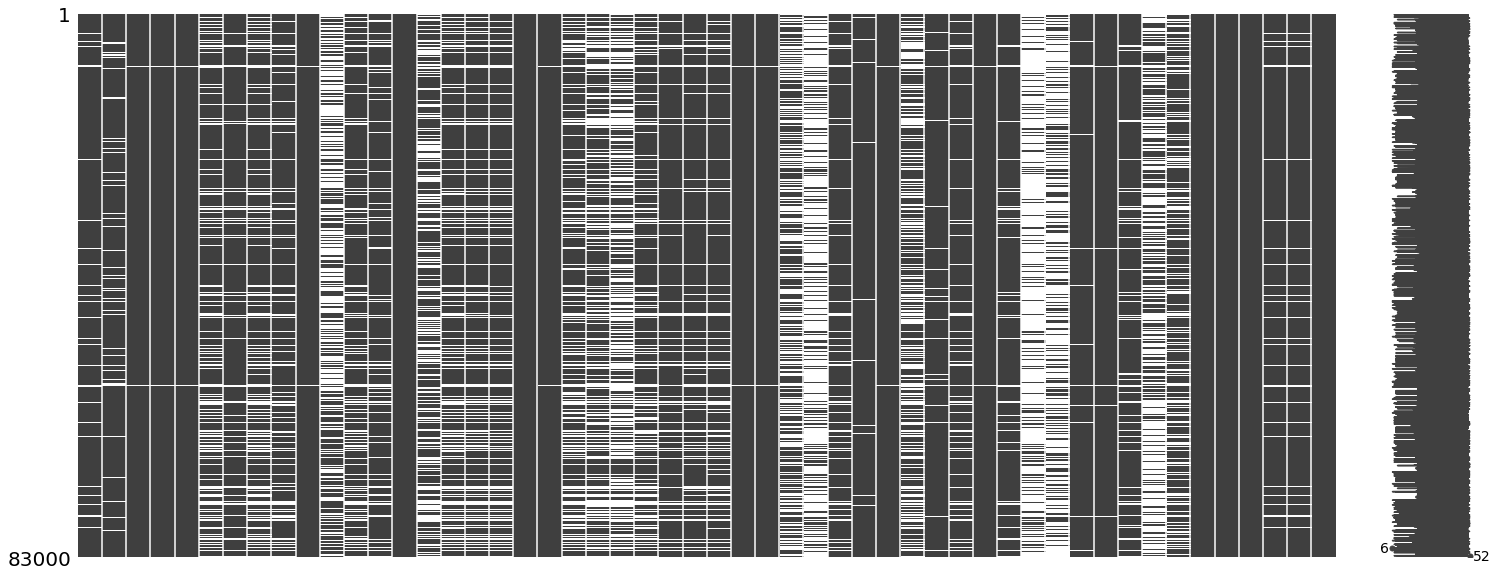

In [20]:
counter = null_counter_columns(train_data)
counter

In [21]:
train_data.describe()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar43,mvar44,mvar45,mvar46,mvar47,mvar48,mvar49,mvar50,mvar51,default_ind
count,79267.000000,77114.000000,82465.000000,82465.000000,82465.000000,63299.000000,7.532600e+04,63291.000000,71318.000000,8.246500e+04,...,82111.000000,74851.000000,37080.000000,59397.000000,83000.000000,83000.000000,83000.000000,79267.000000,79267.000000,83000.000000
mean,1747.511865,1.054816,5.401784,0.461151,1.084012,1633.429280,1.750797e+04,6822.332227,34030.596329,3.022857e+04,...,6.553604,0.706595,0.070523,0.093187,0.372976,556.021277,600.127494,4.285201,2570.704518,0.287410
std,94.830127,1.556682,11.091569,1.704292,5.743899,3667.183981,4.677222e+04,10060.346814,50673.150005,6.617798e+04,...,6.273107,0.245915,0.290383,0.329054,0.483599,1106.953295,144.441805,0.451513,679.544764,0.452557
min,1477.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.060660,0.000000,0.000000,0.000000,2.000000,350.000000,4.000000,1400.000000,0.000000
25%,1680.000000,0.131800,0.000000,0.000000,0.000000,41.000000,1.750250e+03,496.000000,3542.250000,1.153000e+03,...,2.000000,0.515280,0.000000,0.000000,0.000000,8.000000,474.000000,4.000000,2012.000000,0.000000
50%,1743.000000,0.513000,0.300000,0.000000,0.000000,297.000000,7.020500e+03,2507.000000,14389.000000,9.525000e+03,...,5.000000,0.739500,0.000000,0.000000,0.000000,17.000000,601.000000,4.000000,2545.000000,0.000000
75%,1813.000000,1.386200,6.595000,0.000000,0.000000,1381.000000,1.811300e+04,9869.500000,44413.000000,3.428800e+04,...,10.000000,0.945120,0.000000,0.000000,1.000000,111.000000,725.000000,5.000000,3070.000000,1.000000
max,1950.000000,31.018100,399.334000,25.754000,165.492000,94302.000000,5.637108e+06,291810.000000,840658.000000,5.647073e+06,...,91.000000,1.000000,7.000000,5.000000,1.000000,3247.000000,850.000000,5.000000,4250.000000,1.000000


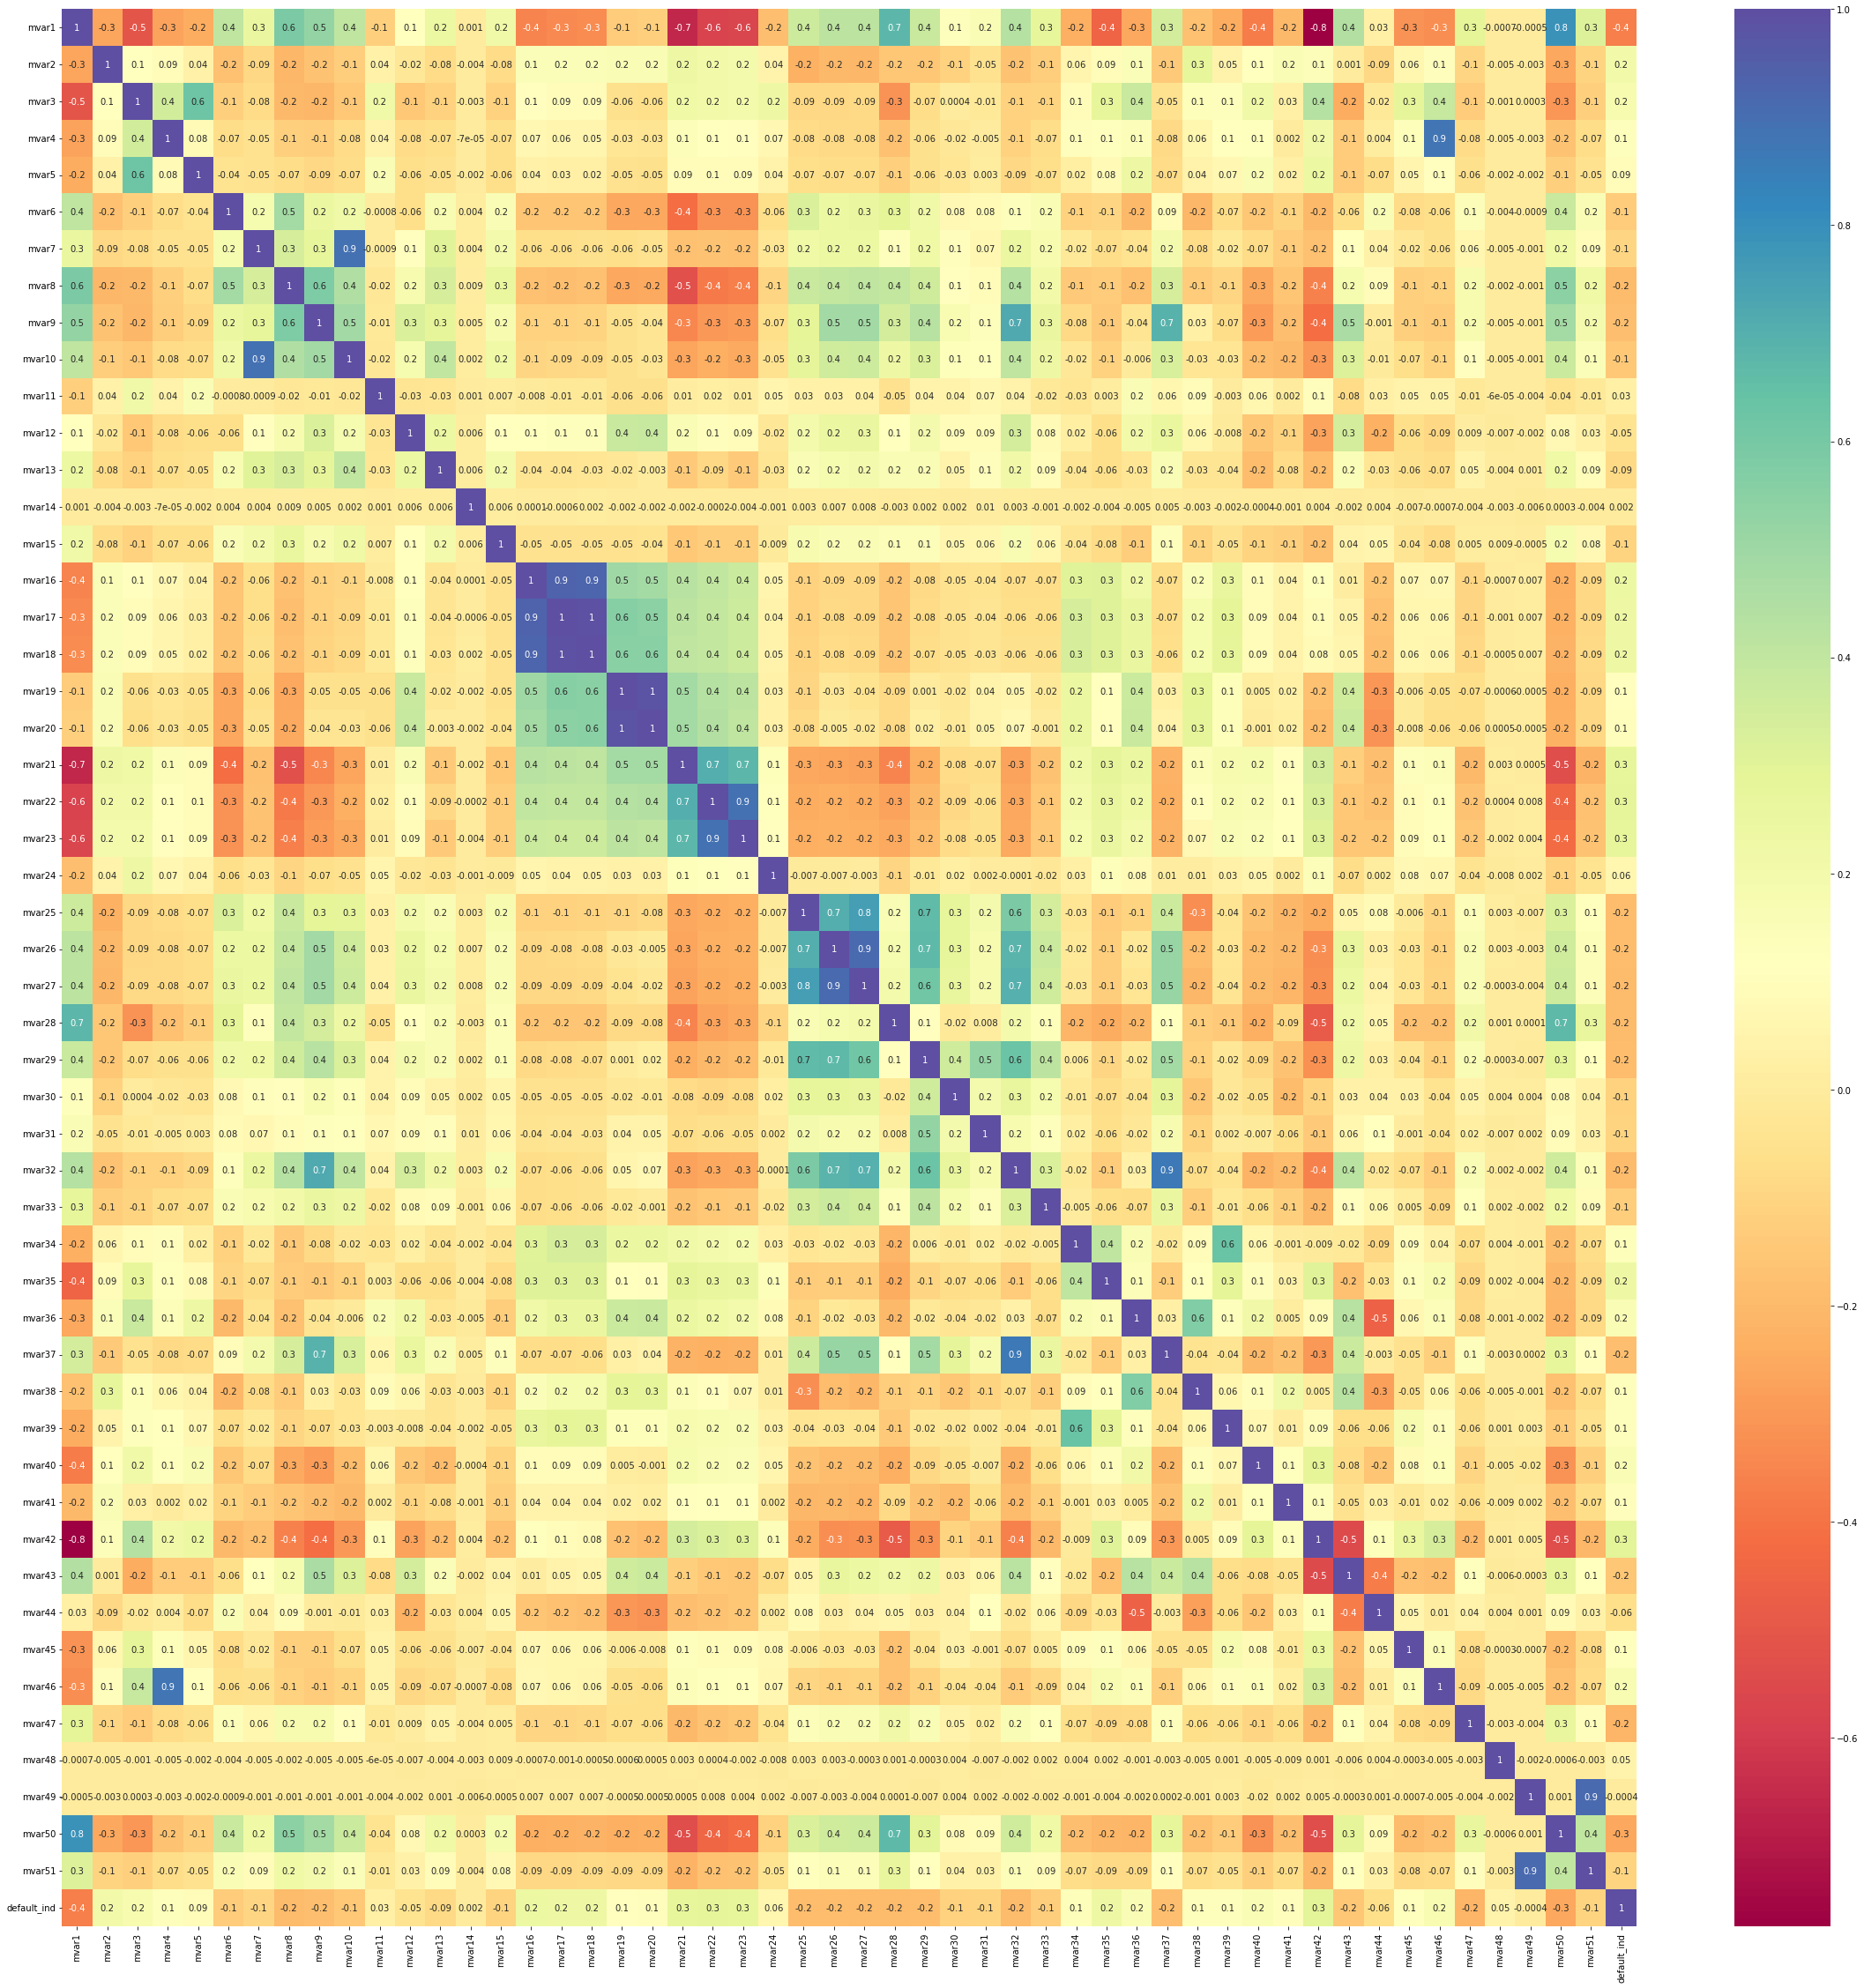

In [22]:
correlation_heatmap(train_data)

In [23]:
train_data['mvar47'].head()

application_key
230032    0.0
230035    1.0
230036    1.0
230039    0.0
230041    1.0
Name: mvar47, dtype: float64

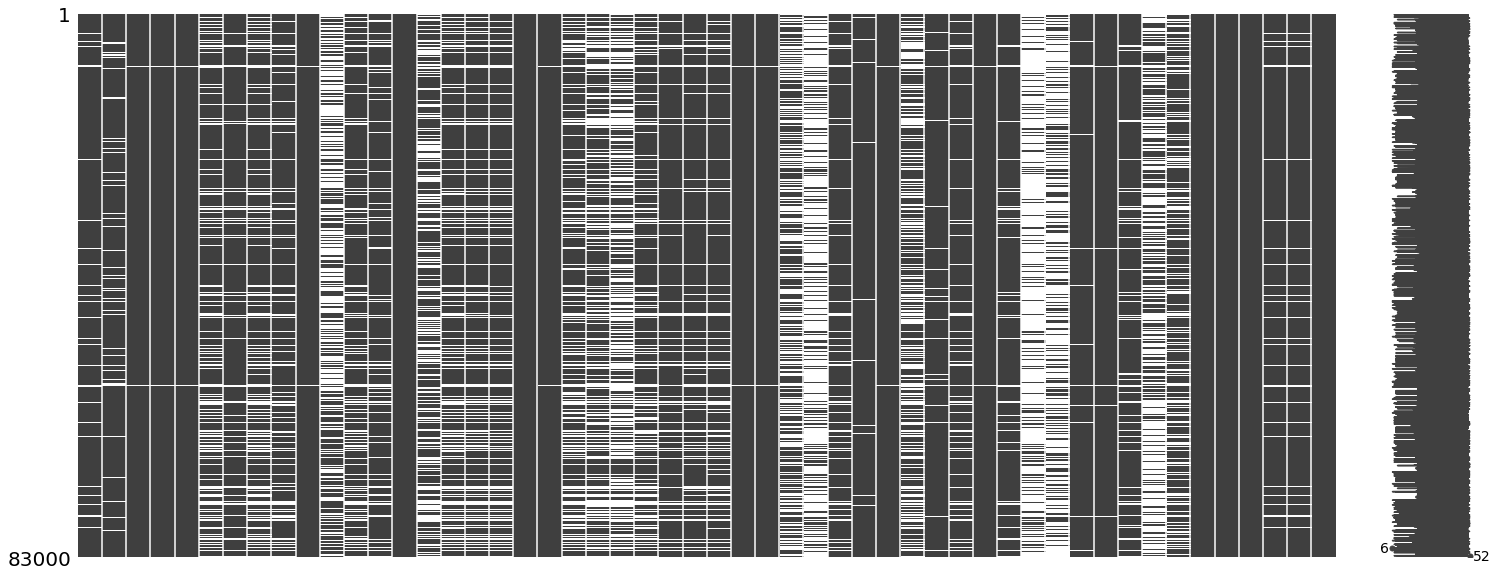

In [24]:
#drop columns
train_data= drop_columns(train_data,0.5)

In [25]:
train_data_copy = train_data.copy()

#### Pre-Processing - Missing Data Imputation and Data Transformation

In [26]:
train_data.drop(['default_ind'],axis=1,inplace=True)

In [27]:
kernel = mf.ImputationKernel(data=train_data,save_all_iterations=True,random_state=2)
kernel.mice(3,verbose=True)

Initialized logger with name mice 1-3
Dataset 0
1  | mvar19 | mvar29 | mvar34 | mvar38 | mvar20 | mvar10 | mvar5 | mvar4 | mvar3 | mvar28 | mvar43 | mvar33 | mvar42 | mvar36 | mvar1 | mvar50 | mvar51 | mvar2 | mvar39 | mvar7 | mvar25 | mvar37 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30
2  | mvar19 | mvar29 | mvar34 | mvar38 | mvar20 | mvar10 | mvar5 | mvar4 | mvar3 | mvar28 | mvar43 | mvar33 | mvar42 | mvar36 | mvar1 | mvar50 | mvar51 | mvar2 | mvar39 | mvar7 | mvar25 | mvar37 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30
3  | mvar19 | mvar29 | mvar34 | mvar38 | mvar20 | mvar10 | mvar5 | mvar4 | mvar3 | mvar28 | mvar43 | mvar33 | mvar42 | mvar36 | mvar1 | mvar50 | mvar51 | mvar2 | mvar39 | mvar7 | mvar25 | mvar37 | mvar32 | mvar44 | mvar13 | mv

In [28]:
new_data_imputed = kernel.impute_new_data(train_data)
new_completed_data = new_data_imputed.complete_data(0)
new_completed_data = pd.DataFrame(data=new_completed_data,columns=train_data.columns,index=train_data.index)

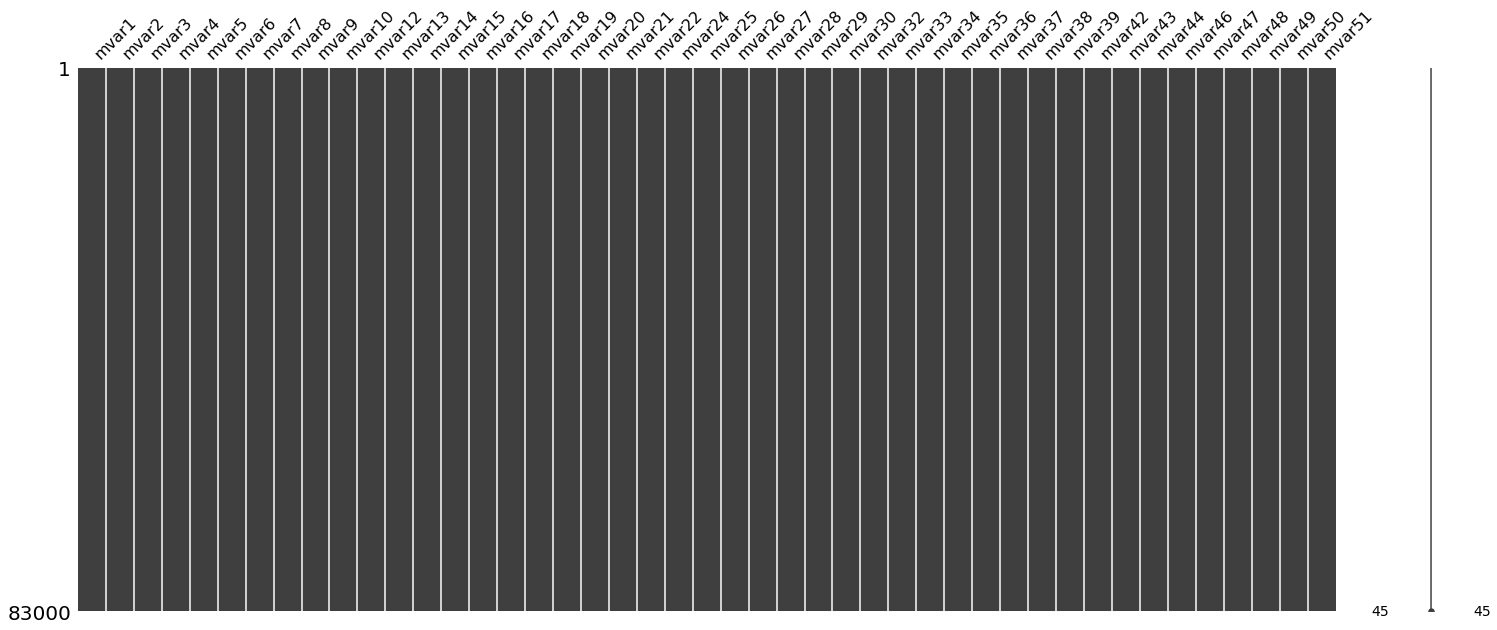

In [29]:
counter = null_counter_columns(new_completed_data)

In [30]:
pt = PowerTransformer()
testing=pt.fit_transform(new_completed_data)
testing = pd.DataFrame(data=testing,columns=new_completed_data.columns,index=train_data.index)

In [31]:
testing['default_ind'] = train_data_copy['default_ind'].copy()

In [32]:
testing.describe()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar42,mvar43,mvar44,mvar46,mvar47,mvar48,mvar49,mvar50,mvar51,default_ind
count,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,...,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,8.300000e+04,83000.000000
mean,-9.376210e-15,-8.435590e-15,-7.529775e-14,1.016004e-14,5.363610e-14,9.765127e-15,-1.148303e-14,-1.719752e-14,3.455909e-15,-1.094386e-14,...,3.811818e-14,-3.930391e-14,2.493523e-15,3.513961e-14,2.341711e-13,-1.710846e-15,2.669267e-16,6.796772e-18,-3.206500e-15,0.287410
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,5.505301e-14,1.000006e+00,0.452557
min,-3.016902e+00,-1.364390e+00,-9.130545e-01,-3.948037e-01,-3.236793e-01,-1.713153e+00,-2.142772e+00,-2.131957e+00,-2.977565e+00,-1.765098e+00,...,-1.122936e+00,-1.664055e+00,-2.059285e+00,-2.511310e-01,-7.712555e-01,-1.502164e+00,-1.796361e+00,-3.418099e-14,-1.963473e+00,0.000000
25%,-7.049797e-01,-9.290530e-01,-9.130545e-01,-3.948037e-01,-3.236793e-01,-5.614197e-01,-6.334886e-01,-7.048643e-01,-7.561707e-01,-6.328043e-01,...,-1.122936e+00,-6.616659e-01,-8.813752e-01,-2.511310e-01,-7.712555e-01,-6.788532e-01,-8.628293e-01,-3.418099e-14,-7.923335e-01,0.000000
50%,-9.097514e-03,-8.920048e-02,-4.875930e-01,-3.948037e-01,-3.236793e-01,8.681649e-03,6.426474e-02,-2.674298e-02,5.143237e-03,1.064272e-01,...,-8.907731e-02,7.626891e-02,4.972081e-02,-2.511310e-01,-7.712555e-01,-2.496109e-01,3.490925e-02,-3.418099e-14,5.066918e-02,0.000000
75%,7.016956e-01,8.694415e-01,1.120480e+00,-3.948037e-01,-3.236793e-01,6.260766e-01,6.520722e-01,7.758689e-01,7.549122e-01,7.169748e-01,...,9.277291e-01,7.983267e-01,1.048750e+00,-2.511310e-01,1.296587e+00,6.222550e-01,8.689756e-01,8.865825e-14,7.725635e-01,1.000000
max,2.064062e+00,2.276340e+00,1.867600e+00,2.659489e+00,3.144278e+00,3.370522e+00,7.345685e+00,3.826068e+00,3.313694e+00,5.294214e+00,...,2.033419e+00,4.019902e+00,1.233896e+00,3.981987e+00,1.296587e+00,1.563384e+00,1.676278e+00,8.865825e-14,2.161765e+00,1.000000


#### Data Transformation Check - Using Distribution Plot and Q-Q Graph

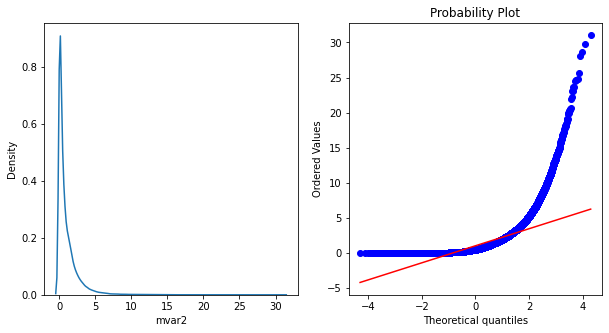

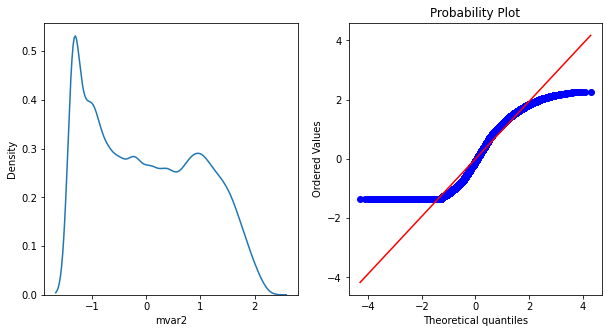

In [33]:
normality(new_completed_data,'mvar2')
normality(testing,'mvar2')

### Principal Component Analysis

In [34]:
pca_testing = pd.DataFrame(data=testing,columns=testing.columns,index=testing.index)
pca_testing.drop(['default_ind'],inplace=True,axis=1)

In [35]:
from sklearn.decomposition import PCA

principal = PCA(n_components=0.95)
principal.fit(pca_testing)
pca_data = principal.transform(pca_testing)
print(pca_data.shape)

(83000, 28)


Text(0, 0.5, 'pc2')

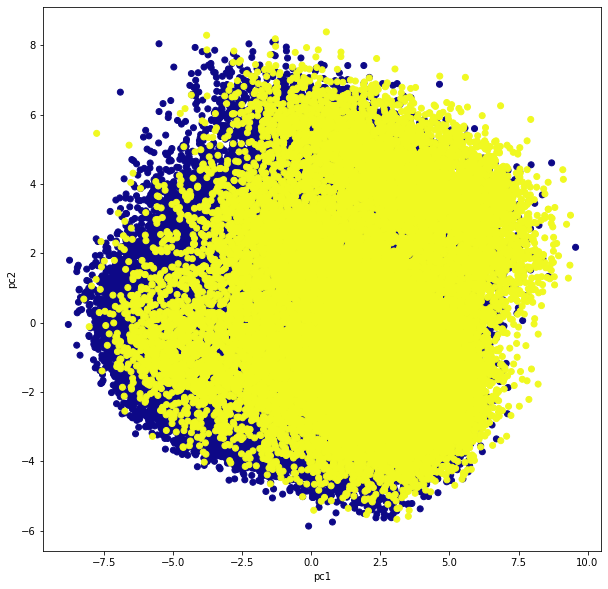

In [36]:
#Plotting component 1 and component 2 - 2D Graph - to explain maximum vaariance in data using 1st - 2 components

plt.figure(figsize=(10,10))
plt.scatter(pca_data[:,0],pca_data[:,1],c=testing['default_ind'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [37]:
print(principal.explained_variance_ratio_)

[0.24379878 0.13268154 0.07999794 0.04988329 0.04306781 0.03968988
 0.03171009 0.02812474 0.02650996 0.02351483 0.02273867 0.02179444
 0.01930628 0.01849819 0.0176653  0.01684691 0.01554899 0.01442029
 0.01392757 0.01360055 0.01214715 0.01168007 0.01077875 0.0101036
 0.00924756 0.00827057 0.00769533 0.00697421]


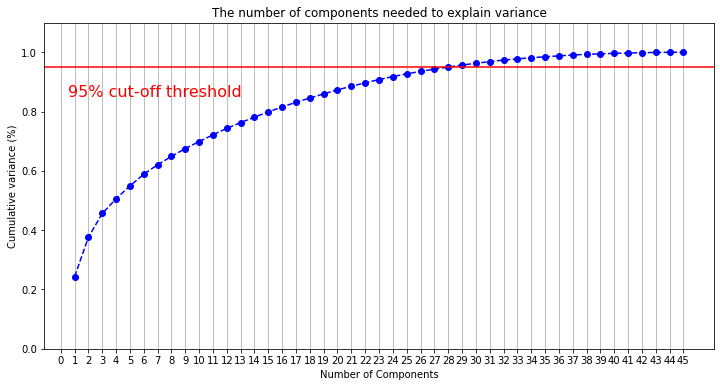

In [38]:
pca = PCA().fit(pca_testing)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 46, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 46, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [39]:
pca_data = pd.DataFrame(pca_data,index=testing.index)
pca_data['default_ind'] = testing['default_ind'].copy()

### Models Training and Testing

#### Logistic Regression

In [40]:
def LogisticRegression_Classifier(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train.values.ravel())
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    
    print("ROC-AUC Score: ",roc_auc_score(y_test,y_pred))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return logreg

In [41]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_lr = LogisticRegression_Classifier(X_train, X_test, y_train, y_test)

Accuracy of logistic regression classifier on test set: 0.77
ROC-AUC Score:  0.654741554634165
Confusion Matrix:
 [[16339  1479]
 [ 4303  2780]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85     17818
         1.0       0.65      0.39      0.49      7083

    accuracy                           0.77     24901
   macro avg       0.72      0.65      0.67     24901
weighted avg       0.75      0.77      0.75     24901



In [42]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_lr_smote = LogisticRegression_Classifier(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Accuracy of logistic regression classifier on test set: 0.71
ROC-AUC Score:  0.7101975254613258
Confusion Matrix:
 [[20522  9039]
 [ 8101 21483]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.69      0.71     29561
         1.0       0.70      0.73      0.71     29584

    accuracy                           0.71     59145
   macro avg       0.71      0.71      0.71     59145
weighted avg       0.71      0.71      0.71     59145



In [43]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_lr_pca = LogisticRegression_Classifier(X_train, X_test, y_train, y_test)

Accuracy of logistic regression classifier on test set: 0.77
ROC-AUC Score:  0.6550774172038051
Confusion Matrix:
 [[16356  1462]
 [ 4305  2778]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85     17818
         1.0       0.66      0.39      0.49      7083

    accuracy                           0.77     24901
   macro avg       0.72      0.66      0.67     24901
weighted avg       0.75      0.77      0.75     24901



In [44]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_lr_pca_smote = LogisticRegression_Classifier(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Accuracy of logistic regression classifier on test set: 0.71
ROC-AUC Score:  0.709873210516158
Confusion Matrix:
 [[20279  9282]
 [ 7877 21707]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.69      0.70     29561
         1.0       0.70      0.73      0.72     29584

    accuracy                           0.71     59145
   macro avg       0.71      0.71      0.71     59145
weighted avg       0.71      0.71      0.71     59145



#### Naive Bayes

In [45]:
def naive_bayes(X_train, X_test, y_train, y_test):

    gnb = BernoulliNB() 
    gnb.fit(X_train, y_train.values.ravel()) 
  
    #Applying and predicting 
    y_pred_nb = gnb.predict(X_test) 
    cv_scores = cross_val_score(gnb, X, y.values.ravel(),cv=10,scoring='precision')
    print("Cross-validation precision: %f" % cv_scores.mean())
    
    print("ROC-AUC Score: ",roc_auc_score(y_test,y_pred_nb))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred_nb)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred_nb))
    
    return gnb

In [46]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_nb = naive_bayes(X_train, X_test, y_train, y_test)

Cross-validation precision: 0.465851
ROC-AUC Score:  0.6921618269415131
Confusion Matrix:
 [[12108  5710]
 [ 2091  4992]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.68      0.76     17818
         1.0       0.47      0.70      0.56      7083

    accuracy                           0.69     24901
   macro avg       0.66      0.69      0.66     24901
weighted avg       0.74      0.69      0.70     24901



In [47]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_nb_smote = naive_bayes(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Cross-validation precision: 0.465851
ROC-AUC Score:  0.6904215908359298
Confusion Matrix:
 [[19105 10456]
 [ 7853 21731]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.65      0.68     29561
         1.0       0.68      0.73      0.70     29584

    accuracy                           0.69     59145
   macro avg       0.69      0.69      0.69     59145
weighted avg       0.69      0.69      0.69     59145



In [48]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_nb_pca = naive_bayes(X_train, X_test, y_train, y_test)

Cross-validation precision: 0.516235
ROC-AUC Score:  0.5836408847980175
Confusion Matrix:
 [[16102  1716]
 [ 5216  1867]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.90      0.82     17818
         1.0       0.52      0.26      0.35      7083

    accuracy                           0.72     24901
   macro avg       0.64      0.58      0.59     24901
weighted avg       0.69      0.72      0.69     24901



In [49]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_nb_pca_smote = naive_bayes(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Cross-validation precision: 0.516235
ROC-AUC Score:  0.6855988279289167
Confusion Matrix:
 [[18651 10910]
 [ 7684 21900]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.63      0.67     29561
         1.0       0.67      0.74      0.70     29584

    accuracy                           0.69     59145
   macro avg       0.69      0.69      0.68     59145
weighted avg       0.69      0.69      0.68     59145



#### Random Forest

In [50]:
def randomforest_classifier(X_train, X_test, y_train, y_test):

    rt=RandomForestClassifier(n_estimators=100,class_weight="balanced_subsample")
    rt.fit(X_train,y_train.values.ravel())
    y_pred=rt.predict(X_test)
    print("Recall:",recall_score(y_test, y_pred))
    roc_value = roc_auc_score(y_test, y_pred)
    print("ROC Value:",roc_value)
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return rt

In [51]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_rf = randomforest_classifier(X_train, X_test, y_train, y_test)

Recall: 0.3447691656077933
ROC Value: 0.6405347680098683
Confusion Matrix:
 [[16683  1135]
 [ 4641  2442]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85     17818
         1.0       0.68      0.34      0.46      7083

    accuracy                           0.77     24901
   macro avg       0.73      0.64      0.66     24901
weighted avg       0.75      0.77      0.74     24901



In [52]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_rf_smote = randomforest_classifier(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Recall: 0.7948215251487291
ROC Value: 0.8133811289354484
Confusion Matrix:
 [[24593  4968]
 [ 6070 23514]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.83      0.82     29561
         1.0       0.83      0.79      0.81     29584

    accuracy                           0.81     59145
   macro avg       0.81      0.81      0.81     59145
weighted avg       0.81      0.81      0.81     59145



In [53]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_rf_pca = randomforest_classifier(X_train, X_test, y_train, y_test)

Recall: 0.325144712692362
ROC Value: 0.6301893728463492
Confusion Matrix:
 [[16664  1154]
 [ 4780  2303]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85     17818
         1.0       0.67      0.33      0.44      7083

    accuracy                           0.76     24901
   macro avg       0.72      0.63      0.64     24901
weighted avg       0.75      0.76      0.73     24901



In [54]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_rf_pca_smote = randomforest_classifier(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Recall: 0.791880746349378
ROC Value: 0.7849326264814107
Confusion Matrix:
 [[22998  6563]
 [ 6157 23427]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.78      0.78     29561
         1.0       0.78      0.79      0.79     29584

    accuracy                           0.78     59145
   macro avg       0.78      0.78      0.78     59145
weighted avg       0.78      0.78      0.78     59145



#### XGBoost

In [55]:
def xgb_classification(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, 
                               alpha = 2, n_estimators = 100)
    xg_reg.fit(X_train,y_train.values.ravel())
    preds = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))
    
    print("ROC-AUC Score: ",roc_auc_score(y_test,preds))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, preds)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, preds))
    
    return xg_reg

In [56]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_xgb = xgb_classification(X_train, X_test, y_train, y_test)

RMSE: 0.472317
ROC-AUC Score:  0.6684266855768684
Confusion Matrix:
 [[16394  1424]
 [ 4131  2952]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.92      0.86     17818
         1.0       0.67      0.42      0.52      7083

    accuracy                           0.78     24901
   macro avg       0.74      0.67      0.69     24901
weighted avg       0.76      0.78      0.76     24901



In [57]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_xgb_smote = xgb_classification(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
RMSE: 0.411538
ROC-AUC Score:  0.8306587228014035
Confusion Matrix:
 [[26239  3322]
 [ 6695 22889]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.89      0.84     29561
         1.0       0.87      0.77      0.82     29584

    accuracy                           0.83     59145
   macro avg       0.83      0.83      0.83     59145
weighted avg       0.84      0.83      0.83     59145



In [58]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_xgb_pca = xgb_classification(X_train, X_test, y_train, y_test)

RMSE: 0.480786
ROC-AUC Score:  0.6539826022911599
Confusion Matrix:
 [[16400  1418]
 [ 4338  2745]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85     17818
         1.0       0.66      0.39      0.49      7083

    accuracy                           0.77     24901
   macro avg       0.73      0.65      0.67     24901
weighted avg       0.75      0.77      0.75     24901



In [59]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_xgb_pca_smote = xgb_classification(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
RMSE: 0.520621
ROC-AUC Score:  0.7289562819099588
Confusion Matrix:
 [[21702  7859]
 [ 8172 21412]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73     29561
         1.0       0.73      0.72      0.73     29584

    accuracy                           0.73     59145
   macro avg       0.73      0.73      0.73     59145
weighted avg       0.73      0.73      0.73     59145



#### Histogram Gradient Boosting Classification

In [60]:
def HistGradientBoostingClassification(X_train, X_test, y_train, y_test):

    clf = HistGradientBoostingClassifier()
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    print('Accuracy of classifier on train set: {:.2f}'.format(clf.score(X_train, y_train)))
    print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
    
    print("ROC-AUC Score: ",roc_auc_score(y_test,y_pred))
    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return clf

In [61]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_hgb = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Accuracy of classifier on train set: 0.80
Accuracy of classifier on test set: 0.78
ROC-AUC Score:  0.668107918223837
Confusion Matrix:
 [[16360  1458]
 [ 4122  2961]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.92      0.85     17818
         1.0       0.67      0.42      0.51      7083

    accuracy                           0.78     24901
   macro avg       0.73      0.67      0.68     24901
weighted avg       0.76      0.78      0.76     24901



In [62]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_hgb_smote = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Accuracy of classifier on train set: 0.85
Accuracy of classifier on test set: 0.83
ROC-AUC Score:  0.8297132383479842
Confusion Matrix:
 [[26313  3248]
 [ 6825 22759]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.89      0.84     29561
         1.0       0.88      0.77      0.82     29584

    accuracy                           0.83     59145
   macro avg       0.83      0.83      0.83     59145
weighted avg       0.83      0.83      0.83     59145



In [63]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_hgb_pca = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Accuracy of classifier on train set: 0.79
Accuracy of classifier on test set: 0.77
ROC-AUC Score:  0.6606993069539758
Confusion Matrix:
 [[16340  1478]
 [ 4219  2864]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85     17818
         1.0       0.66      0.40      0.50      7083

    accuracy                           0.77     24901
   macro avg       0.73      0.66      0.68     24901
weighted avg       0.76      0.77      0.75     24901



In [64]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_hgb_pca_smote = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Accuracy of classifier on train set: 0.77
Accuracy of classifier on test set: 0.73
ROC-AUC Score:  0.7305968650747556
Confusion Matrix:
 [[21792  7769]
 [ 8165 21419]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.74      0.73     29561
         1.0       0.73      0.72      0.73     29584

    accuracy                           0.73     59145
   macro avg       0.73      0.73      0.73     59145
weighted avg       0.73      0.73      0.73     59145



#### CatBoost Classifier

In [65]:
def CatBoost_classifier(X_train, X_test, y_train, y_test,weight):
    
    accuracy= []
    recall =[]
    roc_auc= []
    precision = []
    
    clf = CatBoostClassifier(verbose=True,random_state=42,scale_pos_weight=weight,
                            iterations=300,depth=6,eval_metric="AUC")
    clf.fit(X_train, y_train.values.ravel(),
            eval_set=(X_test,y_test.values.ravel()))
    y_pred = clf.predict(X_test)
    
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    recall.append(round(recall_score(y_test, y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
    precision.append(round(precision_score(y_test, y_pred),4))

    model_names = ['Catboost_default']
    result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
    print(result_df1)
    
    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return clf

In [66]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cb = CatBoost_classifier(X_train, X_test, y_train, y_test,3)

Learning rate set to 0.145919
0:	test: 0.7520257	best: 0.7520257 (0)	total: 243ms	remaining: 1m 12s
1:	test: 0.7649130	best: 0.7649130 (1)	total: 286ms	remaining: 42.6s
2:	test: 0.7677588	best: 0.7677588 (2)	total: 321ms	remaining: 31.7s
3:	test: 0.7703411	best: 0.7703411 (3)	total: 356ms	remaining: 26.4s
4:	test: 0.7721335	best: 0.7721335 (4)	total: 386ms	remaining: 22.7s
5:	test: 0.7727390	best: 0.7727390 (5)	total: 418ms	remaining: 20.5s
6:	test: 0.7741101	best: 0.7741101 (6)	total: 454ms	remaining: 19s
7:	test: 0.7759323	best: 0.7759323 (7)	total: 487ms	remaining: 17.8s
8:	test: 0.7768257	best: 0.7768257 (8)	total: 520ms	remaining: 16.8s
9:	test: 0.7781107	best: 0.7781107 (9)	total: 552ms	remaining: 16s
10:	test: 0.7789716	best: 0.7789716 (10)	total: 586ms	remaining: 15.4s
11:	test: 0.7796848	best: 0.7796848 (11)	total: 620ms	remaining: 14.9s
12:	test: 0.7804689	best: 0.7804689 (12)	total: 651ms	remaining: 14.4s
13:	test: 0.7810175	best: 0.7810175 (13)	total: 688ms	remaining: 14.1s

117:	test: 0.7910633	best: 0.7910912 (109)	total: 4.04s	remaining: 6.23s
118:	test: 0.7909924	best: 0.7910912 (109)	total: 4.07s	remaining: 6.19s
119:	test: 0.7909828	best: 0.7910912 (109)	total: 4.1s	remaining: 6.16s
120:	test: 0.7908930	best: 0.7910912 (109)	total: 4.13s	remaining: 6.12s
121:	test: 0.7909014	best: 0.7910912 (109)	total: 4.17s	remaining: 6.08s
122:	test: 0.7909517	best: 0.7910912 (109)	total: 4.2s	remaining: 6.04s
123:	test: 0.7909752	best: 0.7910912 (109)	total: 4.23s	remaining: 6s
124:	test: 0.7909294	best: 0.7910912 (109)	total: 4.26s	remaining: 5.96s
125:	test: 0.7910269	best: 0.7910912 (109)	total: 4.29s	remaining: 5.93s
126:	test: 0.7910378	best: 0.7910912 (109)	total: 4.33s	remaining: 5.89s
127:	test: 0.7910801	best: 0.7910912 (109)	total: 4.36s	remaining: 5.86s
128:	test: 0.7911724	best: 0.7911724 (128)	total: 4.39s	remaining: 5.82s
129:	test: 0.7912524	best: 0.7912524 (129)	total: 4.42s	remaining: 5.78s
130:	test: 0.7912816	best: 0.7912816 (130)	total: 4.46s	

234:	test: 0.7904196	best: 0.7915165 (144)	total: 7.77s	remaining: 2.15s
235:	test: 0.7904456	best: 0.7915165 (144)	total: 7.8s	remaining: 2.12s
236:	test: 0.7904368	best: 0.7915165 (144)	total: 7.83s	remaining: 2.08s
237:	test: 0.7904363	best: 0.7915165 (144)	total: 7.87s	remaining: 2.05s
238:	test: 0.7903558	best: 0.7915165 (144)	total: 7.9s	remaining: 2.02s
239:	test: 0.7903398	best: 0.7915165 (144)	total: 7.93s	remaining: 1.98s
240:	test: 0.7903633	best: 0.7915165 (144)	total: 7.96s	remaining: 1.95s
241:	test: 0.7903637	best: 0.7915165 (144)	total: 7.99s	remaining: 1.92s
242:	test: 0.7904225	best: 0.7915165 (144)	total: 8.03s	remaining: 1.88s
243:	test: 0.7904495	best: 0.7915165 (144)	total: 8.06s	remaining: 1.85s
244:	test: 0.7903735	best: 0.7915165 (144)	total: 8.09s	remaining: 1.81s
245:	test: 0.7903901	best: 0.7915165 (144)	total: 8.12s	remaining: 1.78s
246:	test: 0.7903469	best: 0.7915165 (144)	total: 8.15s	remaining: 1.75s
247:	test: 0.7902916	best: 0.7915165 (144)	total: 8.1

In [67]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_cb_smote = CatBoost_classifier(X_train, X_test, y_train, y_test,3)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Learning rate set to 0.146563
0:	test: 0.7530848	best: 0.7530848 (0)	total: 42ms	remaining: 12.6s
1:	test: 0.7707885	best: 0.7707885 (1)	total: 81.7ms	remaining: 12.2s
2:	test: 0.7867017	best: 0.7867017 (2)	total: 121ms	remaining: 12s
3:	test: 0.7993338	best: 0.7993338 (3)	total: 158ms	remaining: 11.7s
4:	test: 0.7982529	best: 0.7993338 (3)	total: 199ms	remaining: 11.7s
5:	test: 0.7977833	best: 0.7993338 (3)	total: 241ms	remaining: 11.8s
6:	test: 0.8045528	best: 0.8045528 (6)	total: 280ms	remaining: 11.7s
7:	test: 0.8058975	best: 0.8058975 (7)	total: 319ms	remaining: 11.6s
8:	test: 0.8132668	best: 0.8132668 (8)	total: 358ms	remaining: 11.6s
9:	test: 0.8231891	best: 0.8231891 (9)	total: 395ms	remaining: 11.5s
10:	test: 0.8284828	best: 0.8284828 (10)	total: 436ms	remaining: 11.4s
11:	test: 0.8338525	best: 0.8338525 (11)	total: 476ms	remaining: 11.4s
12:	test: 0.8431844	best: 0.8431844 (

116:	test: 0.9061370	best: 0.9061423 (115)	total: 4.55s	remaining: 7.12s
117:	test: 0.9061447	best: 0.9061447 (117)	total: 4.59s	remaining: 7.08s
118:	test: 0.9062017	best: 0.9062017 (118)	total: 4.63s	remaining: 7.04s
119:	test: 0.9062031	best: 0.9062031 (119)	total: 4.67s	remaining: 7s
120:	test: 0.9062240	best: 0.9062240 (120)	total: 4.71s	remaining: 6.96s
121:	test: 0.9062207	best: 0.9062240 (120)	total: 4.74s	remaining: 6.92s
122:	test: 0.9062209	best: 0.9062240 (120)	total: 4.78s	remaining: 6.88s
123:	test: 0.9062743	best: 0.9062743 (123)	total: 4.82s	remaining: 6.84s
124:	test: 0.9062933	best: 0.9062933 (124)	total: 4.86s	remaining: 6.8s
125:	test: 0.9063351	best: 0.9063351 (125)	total: 4.89s	remaining: 6.76s
126:	test: 0.9063506	best: 0.9063506 (126)	total: 4.93s	remaining: 6.72s
127:	test: 0.9063427	best: 0.9063506 (126)	total: 4.97s	remaining: 6.68s
128:	test: 0.9063507	best: 0.9063507 (128)	total: 5.01s	remaining: 6.65s
129:	test: 0.9063687	best: 0.9063687 (129)	total: 5.05s

233:	test: 0.9083981	best: 0.9083981 (233)	total: 9.01s	remaining: 2.54s
234:	test: 0.9083929	best: 0.9083981 (233)	total: 9.05s	remaining: 2.5s
235:	test: 0.9084063	best: 0.9084063 (235)	total: 9.08s	remaining: 2.46s
236:	test: 0.9084608	best: 0.9084608 (236)	total: 9.12s	remaining: 2.42s
237:	test: 0.9084628	best: 0.9084628 (237)	total: 9.16s	remaining: 2.39s
238:	test: 0.9084899	best: 0.9084899 (238)	total: 9.2s	remaining: 2.35s
239:	test: 0.9084902	best: 0.9084902 (239)	total: 9.24s	remaining: 2.31s
240:	test: 0.9085171	best: 0.9085171 (240)	total: 9.28s	remaining: 2.27s
241:	test: 0.9085276	best: 0.9085276 (241)	total: 9.32s	remaining: 2.23s
242:	test: 0.9085576	best: 0.9085576 (242)	total: 9.36s	remaining: 2.19s
243:	test: 0.9085453	best: 0.9085576 (242)	total: 9.4s	remaining: 2.16s
244:	test: 0.9085256	best: 0.9085576 (242)	total: 9.44s	remaining: 2.12s
245:	test: 0.9085376	best: 0.9085576 (242)	total: 9.48s	remaining: 2.08s
246:	test: 0.9085209	best: 0.9085576 (242)	total: 9.51

In [68]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_cb_pca = CatBoost_classifier(X_train, X_test, y_train, y_test,3)

Learning rate set to 0.145919
0:	test: 0.7442616	best: 0.7442616 (0)	total: 32ms	remaining: 9.58s
1:	test: 0.7519192	best: 0.7519192 (1)	total: 60.4ms	remaining: 9s
2:	test: 0.7585827	best: 0.7585827 (2)	total: 91.9ms	remaining: 9.1s
3:	test: 0.7589961	best: 0.7589961 (3)	total: 123ms	remaining: 9.11s
4:	test: 0.7619601	best: 0.7619601 (4)	total: 155ms	remaining: 9.16s
5:	test: 0.7653024	best: 0.7653024 (5)	total: 189ms	remaining: 9.26s
6:	test: 0.7667741	best: 0.7667741 (6)	total: 221ms	remaining: 9.26s
7:	test: 0.7670963	best: 0.7670963 (7)	total: 255ms	remaining: 9.31s
8:	test: 0.7681175	best: 0.7681175 (8)	total: 287ms	remaining: 9.29s
9:	test: 0.7689842	best: 0.7689842 (9)	total: 319ms	remaining: 9.24s
10:	test: 0.7694400	best: 0.7694400 (10)	total: 350ms	remaining: 9.2s
11:	test: 0.7701904	best: 0.7701904 (11)	total: 382ms	remaining: 9.16s
12:	test: 0.7705269	best: 0.7705269 (12)	total: 412ms	remaining: 9.1s
13:	test: 0.7716276	best: 0.7716276 (13)	total: 445ms	remaining: 9.09s
1

118:	test: 0.7825694	best: 0.7826114 (113)	total: 3.79s	remaining: 5.76s
119:	test: 0.7826236	best: 0.7826236 (119)	total: 3.84s	remaining: 5.77s
120:	test: 0.7826142	best: 0.7826236 (119)	total: 3.87s	remaining: 5.73s
121:	test: 0.7826397	best: 0.7826397 (121)	total: 3.9s	remaining: 5.7s
122:	test: 0.7827474	best: 0.7827474 (122)	total: 3.94s	remaining: 5.66s
123:	test: 0.7827834	best: 0.7827834 (123)	total: 3.97s	remaining: 5.63s
124:	test: 0.7827679	best: 0.7827834 (123)	total: 4s	remaining: 5.6s
125:	test: 0.7827072	best: 0.7827834 (123)	total: 4.03s	remaining: 5.57s
126:	test: 0.7826849	best: 0.7827834 (123)	total: 4.06s	remaining: 5.53s
127:	test: 0.7826938	best: 0.7827834 (123)	total: 4.09s	remaining: 5.5s
128:	test: 0.7826228	best: 0.7827834 (123)	total: 4.12s	remaining: 5.46s
129:	test: 0.7825309	best: 0.7827834 (123)	total: 4.15s	remaining: 5.43s
130:	test: 0.7824297	best: 0.7827834 (123)	total: 4.18s	remaining: 5.39s
131:	test: 0.7824143	best: 0.7827834 (123)	total: 4.21s	re

236:	test: 0.7819454	best: 0.7827834 (123)	total: 7.4s	remaining: 1.97s
237:	test: 0.7820495	best: 0.7827834 (123)	total: 7.43s	remaining: 1.94s
238:	test: 0.7820163	best: 0.7827834 (123)	total: 7.47s	remaining: 1.91s
239:	test: 0.7819276	best: 0.7827834 (123)	total: 7.5s	remaining: 1.87s
240:	test: 0.7819337	best: 0.7827834 (123)	total: 7.53s	remaining: 1.84s
241:	test: 0.7819000	best: 0.7827834 (123)	total: 7.56s	remaining: 1.81s
242:	test: 0.7817751	best: 0.7827834 (123)	total: 7.59s	remaining: 1.78s
243:	test: 0.7817652	best: 0.7827834 (123)	total: 7.62s	remaining: 1.75s
244:	test: 0.7816821	best: 0.7827834 (123)	total: 7.65s	remaining: 1.72s
245:	test: 0.7817459	best: 0.7827834 (123)	total: 7.68s	remaining: 1.69s
246:	test: 0.7817182	best: 0.7827834 (123)	total: 7.71s	remaining: 1.65s
247:	test: 0.7817828	best: 0.7827834 (123)	total: 7.74s	remaining: 1.62s
248:	test: 0.7817413	best: 0.7827834 (123)	total: 7.77s	remaining: 1.59s
249:	test: 0.7817870	best: 0.7827834 (123)	total: 7.8

In [69]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_cb_pca_smote = CatBoost_classifier(X_train, X_test, y_train, y_test,3)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Learning rate set to 0.146563
0:	test: 0.7358089	best: 0.7358089 (0)	total: 34ms	remaining: 10.2s
1:	test: 0.7506717	best: 0.7506717 (1)	total: 69.7ms	remaining: 10.4s
2:	test: 0.7591185	best: 0.7591185 (2)	total: 107ms	remaining: 10.6s
3:	test: 0.7619734	best: 0.7619734 (3)	total: 142ms	remaining: 10.5s
4:	test: 0.7637856	best: 0.7637856 (4)	total: 178ms	remaining: 10.5s
5:	test: 0.7658452	best: 0.7658452 (5)	total: 216ms	remaining: 10.6s
6:	test: 0.7671650	best: 0.7671650 (6)	total: 250ms	remaining: 10.5s
7:	test: 0.7682183	best: 0.7682183 (7)	total: 287ms	remaining: 10.5s
8:	test: 0.7686039	best: 0.7686039 (8)	total: 322ms	remaining: 10.4s
9:	test: 0.7700034	best: 0.7700034 (9)	total: 359ms	remaining: 10.4s
10:	test: 0.7711281	best: 0.7711281 (10)	total: 395ms	remaining: 10.4s
11:	test: 0.7725307	best: 0.7725307 (11)	total: 433ms	remaining: 10.4s
12:	test: 0.7733902	best: 0.7733902

118:	test: 0.8000158	best: 0.8000158 (118)	total: 4.35s	remaining: 6.62s
119:	test: 0.8001555	best: 0.8001555 (119)	total: 4.39s	remaining: 6.58s
120:	test: 0.8002768	best: 0.8002768 (120)	total: 4.42s	remaining: 6.54s
121:	test: 0.8003582	best: 0.8003582 (121)	total: 4.46s	remaining: 6.5s
122:	test: 0.8004524	best: 0.8004524 (122)	total: 4.49s	remaining: 6.46s
123:	test: 0.8005131	best: 0.8005131 (123)	total: 4.53s	remaining: 6.42s
124:	test: 0.8006568	best: 0.8006568 (124)	total: 4.56s	remaining: 6.39s
125:	test: 0.8008353	best: 0.8008353 (125)	total: 4.6s	remaining: 6.35s
126:	test: 0.8009822	best: 0.8009822 (126)	total: 4.63s	remaining: 6.31s
127:	test: 0.8011049	best: 0.8011049 (127)	total: 4.67s	remaining: 6.27s
128:	test: 0.8011878	best: 0.8011878 (128)	total: 4.7s	remaining: 6.24s
129:	test: 0.8012297	best: 0.8012297 (129)	total: 4.74s	remaining: 6.2s
130:	test: 0.8013111	best: 0.8013111 (130)	total: 4.77s	remaining: 6.16s
131:	test: 0.8013750	best: 0.8013750 (131)	total: 4.81s

231:	test: 0.8100208	best: 0.8100208 (231)	total: 8.43s	remaining: 2.47s
232:	test: 0.8100824	best: 0.8100824 (232)	total: 8.46s	remaining: 2.43s
233:	test: 0.8101283	best: 0.8101283 (233)	total: 8.5s	remaining: 2.4s
234:	test: 0.8104689	best: 0.8104689 (234)	total: 8.54s	remaining: 2.36s
235:	test: 0.8105102	best: 0.8105102 (235)	total: 8.57s	remaining: 2.32s
236:	test: 0.8105824	best: 0.8105824 (236)	total: 8.61s	remaining: 2.29s
237:	test: 0.8106438	best: 0.8106438 (237)	total: 8.64s	remaining: 2.25s
238:	test: 0.8107073	best: 0.8107073 (238)	total: 8.68s	remaining: 2.21s
239:	test: 0.8107628	best: 0.8107628 (239)	total: 8.71s	remaining: 2.18s
240:	test: 0.8107912	best: 0.8107912 (240)	total: 8.74s	remaining: 2.14s
241:	test: 0.8108182	best: 0.8108182 (241)	total: 8.78s	remaining: 2.1s
242:	test: 0.8108950	best: 0.8108950 (242)	total: 8.82s	remaining: 2.07s
243:	test: 0.8109438	best: 0.8109438 (243)	total: 8.86s	remaining: 2.03s
244:	test: 0.8109782	best: 0.8109782 (244)	total: 8.89

#### Artificial Neural Network [Architecture - Input, 10, 6, Output(1) ]

In [70]:
def ann_classification(X_train, X_test, y_train, y_test,w):
    
    weights = {0:1,1:w}
    #initializing model
    ann = tf.keras.models.Sequential()

    #adding hidden layers
    #first layer
    ann.add(tf.keras.layers.Dense(units=10,activation="relu"))
    #second layer
    ann.add(tf.keras.layers.Dense(units=6,activation="relu"))

    #output layer - using only 1 neuron - since binary decision variable
    #binary classification - sigmoid, (use "softmax" for multiclass classification)
    ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

    #compiling model
    #loss:- specifies which loss function should be used. 
    #For binary classification, the value should be binary_crossentropy. 
    #For multiclass classification, it should be categorical_crossentropy.

    ann.compile(optimizer="sgd",loss="binary_crossentropy",
                metrics=[tf.keras.metrics.AUC()])

    #model fitting
    #X_train:- Matrix of features for the training dataset
    #Y_train:- Dependent variable vectors for the training dataset
    #batch_size: how many observations should be there in the batch. Usually, the value for this parameter is 32 but we can experiment with any other value as well.
    #epochs: How many times neural networks will be trained. Here the optimal value that I have found from my experience is 100.

    ann.fit(X_train,y_train,batch_size=32,epochs=50,class_weight=weights)
    ann.save("/content/drive/MyDrive/7. Quarter 6/PPDA/Ann.h5")
    score_ann = ann.evaluate(X_test, y_test, verbose = 0) 

    print('Test loss:', score_ann[0]) 
    print('Test AUC:', score_ann[1])
    y_pred_ann = ann.predict(X_test)
    y_pred_ann = np.round_(y_pred_ann)
    
    print("ROC-AUC Score: ",roc_auc_score(y_test,y_pred_ann))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred_ann)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred_ann))
    
    return ann

In [71]:
#transformed_data

X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_ann = ann_classification(X_train, X_test, y_train, y_test,3)

Epoch 1/50
1816/1816 [==============================] - 9s 4ms/step - loss: 0.9444 - auc: 0.7377
Epoch 2/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.9055 - auc: 0.7667
Epoch 3/50
1816/1816 [==============================] - 8s 4ms/step - loss: 0.8991 - auc: 0.7708
Epoch 4/50
1816/1816 [==============================] - 8s 4ms/step - loss: 0.8961 - auc: 0.7726
Epoch 5/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.8945 - auc: 0.7737
Epoch 6/50
1816/1816 [==============================] - 8s 4ms/step - loss: 0.8932 - auc: 0.7745
Epoch 7/50
1816/1816 [==============================] - 6s 4ms/step - loss: 0.8920 - auc: 0.7753
Epoch 8/50
1816/1816 [==============================] - 8s 4ms/step - loss: 0.8913 - auc: 0.7757
Epoch 9/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.8910 - auc: 0.7760
Epoch 10/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.8903 - auc: 0.7764
Epoch 11/50
1816/1816 [======

In [72]:
#transformed_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_ann_smote = ann_classification(X_train, X_test, y_train, y_test,3)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Epoch 1/50
1849/1849 [==============================] - 9s 4ms/step - loss: 0.9786 - auc_1: 0.7500
Epoch 2/50
1849/1849 [==============================] - 8s 4ms/step - loss: 0.9373 - auc_1: 0.7756
Epoch 3/50
1849/1849 [==============================] - 8s 4ms/step - loss: 0.9308 - auc_1: 0.7796
Epoch 4/50
1849/1849 [==============================] - 8s 4ms/step - loss: 0.9272 - auc_1: 0.7818
Epoch 5/50
1849/1849 [==============================] - 7s 4ms/step - loss: 0.9246 - auc_1: 0.7832
Epoch 6/50
1849/1849 [==============================] - 7s 4ms/step - loss: 0.9228 - auc_1: 0.7842
Epoch 7/50
1849/1849 [==============================] - 7s 4ms/step - loss: 0.9215 - auc_1: 0.7850
Epoch 8/50
1849/1849 [==============================] - 8s 4ms/step - loss: 0.9201 - auc_1: 0.7857
Epoch 9/50
1849/1849 [==============================] - 8s 4ms/step - loss: 0.9191 - auc_1: 0.7863
Epoch 

In [73]:
#pca_data

X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_ann_pca = ann_classification(X_train, X_test, y_train, y_test,3)

Epoch 1/50
1816/1816 [==============================] - 8s 4ms/step - loss: 0.9548 - auc_2: 0.7296
Epoch 2/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.9137 - auc_2: 0.7607
Epoch 3/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.9058 - auc_2: 0.7661
Epoch 4/50
1816/1816 [==============================] - 5s 3ms/step - loss: 0.9015 - auc_2: 0.7689
Epoch 5/50
1816/1816 [==============================] - 7s 4ms/step - loss: 0.8988 - auc_2: 0.7709
Epoch 6/50
1816/1816 [==============================] - 5s 2ms/step - loss: 0.8973 - auc_2: 0.7717
Epoch 7/50
1816/1816 [==============================] - 6s 3ms/step - loss: 0.8962 - auc_2: 0.7726
Epoch 8/50
1816/1816 [==============================] - 6s 3ms/step - loss: 0.8954 - auc_2: 0.7730
Epoch 9/50
1816/1816 [==============================] - 4s 2ms/step - loss: 0.8948 - auc_2: 0.7735
Epoch 10/50
1816/1816 [==============================] - 5s 3ms/step - loss: 0.8940 - auc_2: 0.7740
Epoch 11/

In [74]:
#pca_data_smote

X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_ann_pca_smote = ann_classification(X_train, X_test, y_train, y_test,3)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Epoch 1/50
1849/1849 [==============================] - 8s 4ms/step - loss: 0.9948 - auc_3: 0.7353
Epoch 2/50
1849/1849 [==============================] - 6s 3ms/step - loss: 0.9496 - auc_3: 0.7680
Epoch 3/50
1849/1849 [==============================] - 6s 3ms/step - loss: 0.9406 - auc_3: 0.7739
Epoch 4/50
1849/1849 [==============================] - 6s 3ms/step - loss: 0.9363 - auc_3: 0.7766
Epoch 5/50
1849/1849 [==============================] - 5s 3ms/step - loss: 0.9332 - auc_3: 0.7786
Epoch 6/50
1849/1849 [==============================] - 5s 3ms/step - loss: 0.9305 - auc_3: 0.7801
Epoch 7/50
1849/1849 [==============================] - 6s 3ms/step - loss: 0.9288 - auc_3: 0.7811
Epoch 8/50
1849/1849 [==============================] - 5s 3ms/step - loss: 0.9272 - auc_3: 0.7821
Epoch 9/50
1849/1849 [==============================] - 7s 4ms/step - loss: 0.9259 - auc_3: 0.7828
Epoch 

#### CatBoost Tuning

##### CatBoost HyperParameter Optimization

In [ ]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)

In [ ]:
params = {'iterations': [200,300,400],
          'depth': [5, 6, 7],
          'l2_leaf_reg': np.logspace(-20, 3),
          'eval_metric': ['AUC'],
          'random_seed': [42]
         }

clf = CatBoostClassifier(verbose=True,scale_pos_weight=2.6)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring='roc_auc', cv=5)


clf_grid.fit(X, y)
best_param = clf_grid.best_params_

In [ ]:
best_param

##### Weight Optimization

In [75]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_2_5 = CatBoost_classifier(X_train, X_test, y_train, y_test,2.5)

Learning rate set to 0.145919
0:	test: 0.7582502	best: 0.7582502 (0)	total: 34.9ms	remaining: 10.4s
1:	test: 0.7635718	best: 0.7635718 (1)	total: 66ms	remaining: 9.84s
2:	test: 0.7683371	best: 0.7683371 (2)	total: 95.8ms	remaining: 9.48s
3:	test: 0.7698049	best: 0.7698049 (3)	total: 128ms	remaining: 9.44s
4:	test: 0.7714087	best: 0.7714087 (4)	total: 154ms	remaining: 9.09s
5:	test: 0.7726296	best: 0.7726296 (5)	total: 177ms	remaining: 8.65s
6:	test: 0.7742942	best: 0.7742942 (6)	total: 205ms	remaining: 8.56s
7:	test: 0.7759580	best: 0.7759580 (7)	total: 236ms	remaining: 8.61s
8:	test: 0.7766356	best: 0.7766356 (8)	total: 266ms	remaining: 8.61s
9:	test: 0.7770483	best: 0.7770483 (9)	total: 295ms	remaining: 8.55s
10:	test: 0.7784018	best: 0.7784018 (10)	total: 324ms	remaining: 8.51s
11:	test: 0.7788253	best: 0.7788253 (11)	total: 347ms	remaining: 8.33s
12:	test: 0.7798206	best: 0.7798206 (12)	total: 375ms	remaining: 8.27s
13:	test: 0.7805526	best: 0.7805526 (13)	total: 400ms	remaining: 8

117:	test: 0.7909051	best: 0.7909051 (117)	total: 3.29s	remaining: 5.08s
118:	test: 0.7907905	best: 0.7909051 (117)	total: 3.32s	remaining: 5.05s
119:	test: 0.7910234	best: 0.7910234 (119)	total: 3.35s	remaining: 5.03s
120:	test: 0.7910772	best: 0.7910772 (120)	total: 3.38s	remaining: 5s
121:	test: 0.7909850	best: 0.7910772 (120)	total: 3.41s	remaining: 4.98s
122:	test: 0.7909132	best: 0.7910772 (120)	total: 3.44s	remaining: 4.95s
123:	test: 0.7908982	best: 0.7910772 (120)	total: 3.46s	remaining: 4.92s
124:	test: 0.7909502	best: 0.7910772 (120)	total: 3.49s	remaining: 4.88s
125:	test: 0.7909469	best: 0.7910772 (120)	total: 3.52s	remaining: 4.86s
126:	test: 0.7909444	best: 0.7910772 (120)	total: 3.54s	remaining: 4.83s
127:	test: 0.7909195	best: 0.7910772 (120)	total: 3.58s	remaining: 4.8s
128:	test: 0.7908014	best: 0.7910772 (120)	total: 3.6s	remaining: 4.78s
129:	test: 0.7907292	best: 0.7910772 (120)	total: 3.63s	remaining: 4.75s
130:	test: 0.7907444	best: 0.7910772 (120)	total: 3.67s	

230:	test: 0.7896050	best: 0.7910772 (120)	total: 6.38s	remaining: 1.91s
231:	test: 0.7896532	best: 0.7910772 (120)	total: 6.41s	remaining: 1.88s
232:	test: 0.7896356	best: 0.7910772 (120)	total: 6.44s	remaining: 1.85s
233:	test: 0.7896596	best: 0.7910772 (120)	total: 6.47s	remaining: 1.82s
234:	test: 0.7896085	best: 0.7910772 (120)	total: 6.5s	remaining: 1.8s
235:	test: 0.7896272	best: 0.7910772 (120)	total: 6.52s	remaining: 1.77s
236:	test: 0.7896336	best: 0.7910772 (120)	total: 6.55s	remaining: 1.74s
237:	test: 0.7896250	best: 0.7910772 (120)	total: 6.58s	remaining: 1.71s
238:	test: 0.7896164	best: 0.7910772 (120)	total: 6.61s	remaining: 1.69s
239:	test: 0.7895954	best: 0.7910772 (120)	total: 6.64s	remaining: 1.66s
240:	test: 0.7895390	best: 0.7910772 (120)	total: 6.67s	remaining: 1.63s
241:	test: 0.7894654	best: 0.7910772 (120)	total: 6.7s	remaining: 1.6s
242:	test: 0.7893873	best: 0.7910772 (120)	total: 6.73s	remaining: 1.58s
243:	test: 0.7893557	best: 0.7910772 (120)	total: 6.76s

In [76]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_2_6 = CatBoost_classifier(X_train, X_test, y_train, y_test,2.6)

Learning rate set to 0.145919
0:	test: 0.7582502	best: 0.7582502 (0)	total: 34.3ms	remaining: 10.3s
1:	test: 0.7642179	best: 0.7642179 (1)	total: 69.8ms	remaining: 10.4s
2:	test: 0.7674625	best: 0.7674625 (2)	total: 103ms	remaining: 10.2s
3:	test: 0.7685394	best: 0.7685394 (3)	total: 139ms	remaining: 10.3s
4:	test: 0.7689741	best: 0.7689741 (4)	total: 172ms	remaining: 10.1s
5:	test: 0.7715482	best: 0.7715482 (5)	total: 206ms	remaining: 10.1s
6:	test: 0.7735293	best: 0.7735293 (6)	total: 247ms	remaining: 10.4s
7:	test: 0.7748482	best: 0.7748482 (7)	total: 286ms	remaining: 10.5s
8:	test: 0.7755430	best: 0.7755430 (8)	total: 322ms	remaining: 10.4s
9:	test: 0.7770132	best: 0.7770132 (9)	total: 361ms	remaining: 10.5s
10:	test: 0.7780871	best: 0.7780871 (10)	total: 397ms	remaining: 10.4s
11:	test: 0.7788867	best: 0.7788867 (11)	total: 430ms	remaining: 10.3s
12:	test: 0.7793243	best: 0.7793243 (12)	total: 467ms	remaining: 10.3s
13:	test: 0.7800071	best: 0.7800071 (13)	total: 503ms	remaining: 

116:	test: 0.7910003	best: 0.7910003 (116)	total: 3.39s	remaining: 5.3s
117:	test: 0.7910772	best: 0.7910772 (117)	total: 3.41s	remaining: 5.26s
118:	test: 0.7911263	best: 0.7911263 (118)	total: 3.44s	remaining: 5.23s
119:	test: 0.7913023	best: 0.7913023 (119)	total: 3.47s	remaining: 5.2s
120:	test: 0.7913503	best: 0.7913503 (120)	total: 3.5s	remaining: 5.17s
121:	test: 0.7914313	best: 0.7914313 (121)	total: 3.52s	remaining: 5.14s
122:	test: 0.7914572	best: 0.7914572 (122)	total: 3.54s	remaining: 5.1s
123:	test: 0.7914094	best: 0.7914572 (122)	total: 3.57s	remaining: 5.07s
124:	test: 0.7914921	best: 0.7914921 (124)	total: 3.6s	remaining: 5.04s
125:	test: 0.7915063	best: 0.7915063 (125)	total: 3.63s	remaining: 5.01s
126:	test: 0.7914314	best: 0.7915063 (125)	total: 3.66s	remaining: 4.98s
127:	test: 0.7913282	best: 0.7915063 (125)	total: 3.69s	remaining: 4.95s
128:	test: 0.7912974	best: 0.7915063 (125)	total: 3.71s	remaining: 4.92s
129:	test: 0.7912656	best: 0.7915063 (125)	total: 3.74s	

229:	test: 0.7909344	best: 0.7919411 (161)	total: 6.47s	remaining: 1.97s
230:	test: 0.7909107	best: 0.7919411 (161)	total: 6.5s	remaining: 1.94s
231:	test: 0.7909216	best: 0.7919411 (161)	total: 6.52s	remaining: 1.91s
232:	test: 0.7909025	best: 0.7919411 (161)	total: 6.55s	remaining: 1.88s
233:	test: 0.7909112	best: 0.7919411 (161)	total: 6.58s	remaining: 1.86s
234:	test: 0.7907762	best: 0.7919411 (161)	total: 6.61s	remaining: 1.83s
235:	test: 0.7907599	best: 0.7919411 (161)	total: 6.63s	remaining: 1.8s
236:	test: 0.7908020	best: 0.7919411 (161)	total: 6.66s	remaining: 1.77s
237:	test: 0.7907520	best: 0.7919411 (161)	total: 6.68s	remaining: 1.74s
238:	test: 0.7908329	best: 0.7919411 (161)	total: 6.7s	remaining: 1.71s
239:	test: 0.7907993	best: 0.7919411 (161)	total: 6.73s	remaining: 1.68s
240:	test: 0.7907639	best: 0.7919411 (161)	total: 6.75s	remaining: 1.65s
241:	test: 0.7907654	best: 0.7919411 (161)	total: 6.78s	remaining: 1.63s
242:	test: 0.7907409	best: 0.7919411 (161)	total: 6.81

In [77]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_2_7 = CatBoost_classifier(X_train, X_test, y_train, y_test,2.7)

Learning rate set to 0.145919
0:	test: 0.7582502	best: 0.7582502 (0)	total: 31.5ms	remaining: 9.41s
1:	test: 0.7637529	best: 0.7637529 (1)	total: 59.6ms	remaining: 8.88s
2:	test: 0.7684181	best: 0.7684181 (2)	total: 87.3ms	remaining: 8.65s
3:	test: 0.7691954	best: 0.7691954 (3)	total: 117ms	remaining: 8.65s
4:	test: 0.7704788	best: 0.7704788 (4)	total: 149ms	remaining: 8.79s
5:	test: 0.7727095	best: 0.7727095 (5)	total: 179ms	remaining: 8.75s
6:	test: 0.7746255	best: 0.7746255 (6)	total: 211ms	remaining: 8.82s
7:	test: 0.7763987	best: 0.7763987 (7)	total: 242ms	remaining: 8.85s
8:	test: 0.7778126	best: 0.7778126 (8)	total: 273ms	remaining: 8.82s
9:	test: 0.7791372	best: 0.7791372 (9)	total: 302ms	remaining: 8.76s
10:	test: 0.7796046	best: 0.7796046 (10)	total: 334ms	remaining: 8.78s
11:	test: 0.7801033	best: 0.7801033 (11)	total: 365ms	remaining: 8.76s
12:	test: 0.7805289	best: 0.7805289 (12)	total: 394ms	remaining: 8.7s
13:	test: 0.7808776	best: 0.7808776 (13)	total: 424ms	remaining: 

118:	test: 0.7911255	best: 0.7911956 (116)	total: 3.3s	remaining: 5.02s
119:	test: 0.7912380	best: 0.7912380 (119)	total: 3.33s	remaining: 5s
120:	test: 0.7912670	best: 0.7912670 (120)	total: 3.36s	remaining: 4.97s
121:	test: 0.7912248	best: 0.7912670 (120)	total: 3.38s	remaining: 4.93s
122:	test: 0.7910932	best: 0.7912670 (120)	total: 3.4s	remaining: 4.89s
123:	test: 0.7910540	best: 0.7912670 (120)	total: 3.42s	remaining: 4.85s
124:	test: 0.7910459	best: 0.7912670 (120)	total: 3.44s	remaining: 4.82s
125:	test: 0.7911212	best: 0.7912670 (120)	total: 3.48s	remaining: 4.8s
126:	test: 0.7911005	best: 0.7912670 (120)	total: 3.5s	remaining: 4.78s
127:	test: 0.7910946	best: 0.7912670 (120)	total: 3.54s	remaining: 4.75s
128:	test: 0.7910965	best: 0.7912670 (120)	total: 3.56s	remaining: 4.72s
129:	test: 0.7911195	best: 0.7912670 (120)	total: 3.59s	remaining: 4.7s
130:	test: 0.7911457	best: 0.7912670 (120)	total: 3.62s	remaining: 4.67s
131:	test: 0.7911522	best: 0.7912670 (120)	total: 3.64s	rem

231:	test: 0.7900841	best: 0.7913257 (154)	total: 6.37s	remaining: 1.87s
232:	test: 0.7899756	best: 0.7913257 (154)	total: 6.39s	remaining: 1.84s
233:	test: 0.7899775	best: 0.7913257 (154)	total: 6.41s	remaining: 1.81s
234:	test: 0.7899505	best: 0.7913257 (154)	total: 6.43s	remaining: 1.78s
235:	test: 0.7900215	best: 0.7913257 (154)	total: 6.46s	remaining: 1.75s
236:	test: 0.7899881	best: 0.7913257 (154)	total: 6.49s	remaining: 1.73s
237:	test: 0.7899869	best: 0.7913257 (154)	total: 6.52s	remaining: 1.7s
238:	test: 0.7899708	best: 0.7913257 (154)	total: 6.54s	remaining: 1.67s
239:	test: 0.7899694	best: 0.7913257 (154)	total: 6.57s	remaining: 1.64s
240:	test: 0.7899291	best: 0.7913257 (154)	total: 6.6s	remaining: 1.61s
241:	test: 0.7898766	best: 0.7913257 (154)	total: 6.62s	remaining: 1.59s
242:	test: 0.7898116	best: 0.7913257 (154)	total: 6.64s	remaining: 1.56s
243:	test: 0.7897748	best: 0.7913257 (154)	total: 6.67s	remaining: 1.53s
244:	test: 0.7897817	best: 0.7913257 (154)	total: 6.7

In [78]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_2_8 = CatBoost_classifier(X_train, X_test, y_train, y_test,2.8)

Learning rate set to 0.145919
0:	test: 0.7582502	best: 0.7582502 (0)	total: 35.6ms	remaining: 10.6s
1:	test: 0.7637531	best: 0.7637531 (1)	total: 70.1ms	remaining: 10.4s
2:	test: 0.7684169	best: 0.7684169 (2)	total: 98.1ms	remaining: 9.71s
3:	test: 0.7690085	best: 0.7690085 (3)	total: 130ms	remaining: 9.64s
4:	test: 0.7701378	best: 0.7701378 (4)	total: 156ms	remaining: 9.22s
5:	test: 0.7711126	best: 0.7711126 (5)	total: 192ms	remaining: 9.39s
6:	test: 0.7720982	best: 0.7720982 (6)	total: 224ms	remaining: 9.36s
7:	test: 0.7742031	best: 0.7742031 (7)	total: 256ms	remaining: 9.33s
8:	test: 0.7760184	best: 0.7760184 (8)	total: 286ms	remaining: 9.23s
9:	test: 0.7762500	best: 0.7762500 (9)	total: 318ms	remaining: 9.21s
10:	test: 0.7773565	best: 0.7773565 (10)	total: 349ms	remaining: 9.17s
11:	test: 0.7785336	best: 0.7785336 (11)	total: 377ms	remaining: 9.05s
12:	test: 0.7793899	best: 0.7793899 (12)	total: 408ms	remaining: 9.01s
13:	test: 0.7800948	best: 0.7800948 (13)	total: 439ms	remaining:

117:	test: 0.7906701	best: 0.7906701 (117)	total: 3.36s	remaining: 5.19s
118:	test: 0.7907627	best: 0.7907627 (118)	total: 3.39s	remaining: 5.16s
119:	test: 0.7908438	best: 0.7908438 (119)	total: 3.42s	remaining: 5.13s
120:	test: 0.7908550	best: 0.7908550 (120)	total: 3.44s	remaining: 5.09s
121:	test: 0.7907373	best: 0.7908550 (120)	total: 3.46s	remaining: 5.05s
122:	test: 0.7907955	best: 0.7908550 (120)	total: 3.5s	remaining: 5.03s
123:	test: 0.7907705	best: 0.7908550 (120)	total: 3.53s	remaining: 5s
124:	test: 0.7908031	best: 0.7908550 (120)	total: 3.55s	remaining: 4.98s
125:	test: 0.7908358	best: 0.7908550 (120)	total: 3.59s	remaining: 4.95s
126:	test: 0.7908415	best: 0.7908550 (120)	total: 3.62s	remaining: 4.92s
127:	test: 0.7908046	best: 0.7908550 (120)	total: 3.63s	remaining: 4.88s
128:	test: 0.7908095	best: 0.7908550 (120)	total: 3.66s	remaining: 4.85s
129:	test: 0.7907602	best: 0.7908550 (120)	total: 3.69s	remaining: 4.82s
130:	test: 0.7907237	best: 0.7908550 (120)	total: 3.71s

231:	test: 0.7901024	best: 0.7908550 (120)	total: 6.53s	remaining: 1.91s
232:	test: 0.7901691	best: 0.7908550 (120)	total: 6.56s	remaining: 1.89s
233:	test: 0.7901532	best: 0.7908550 (120)	total: 6.59s	remaining: 1.86s
234:	test: 0.7901804	best: 0.7908550 (120)	total: 6.63s	remaining: 1.83s
235:	test: 0.7901286	best: 0.7908550 (120)	total: 6.66s	remaining: 1.8s
236:	test: 0.7901122	best: 0.7908550 (120)	total: 6.68s	remaining: 1.78s
237:	test: 0.7901015	best: 0.7908550 (120)	total: 6.72s	remaining: 1.75s
238:	test: 0.7901371	best: 0.7908550 (120)	total: 6.75s	remaining: 1.72s
239:	test: 0.7901530	best: 0.7908550 (120)	total: 6.78s	remaining: 1.7s
240:	test: 0.7900605	best: 0.7908550 (120)	total: 6.81s	remaining: 1.67s
241:	test: 0.7900193	best: 0.7908550 (120)	total: 6.84s	remaining: 1.64s
242:	test: 0.7899502	best: 0.7908550 (120)	total: 6.87s	remaining: 1.61s
243:	test: 0.7899908	best: 0.7908550 (120)	total: 6.91s	remaining: 1.58s
244:	test: 0.7899179	best: 0.7908550 (120)	total: 6.9

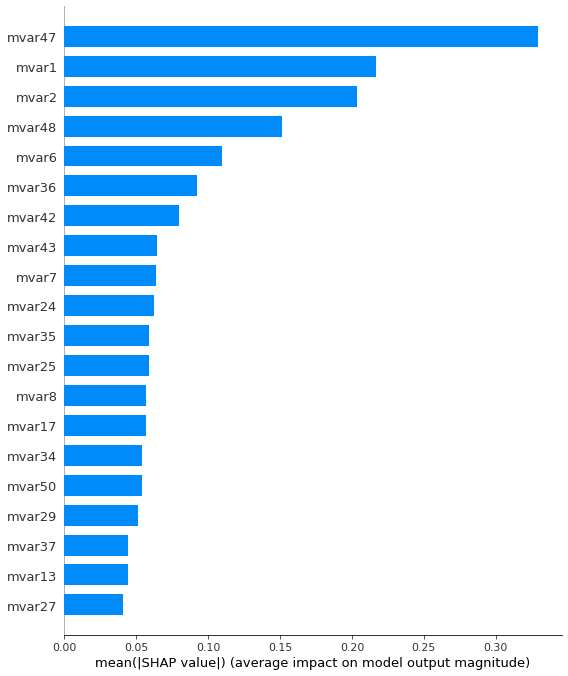

In [79]:
explainercat = shap.TreeExplainer(model_cat_2_6)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

## TestX Data - Input Sanitization and Model Output

In [80]:
test_data = load_dataset('testX.csv')
test_data.set_index('application_key',inplace=True)
test_data = uniform_nan(test_data)
test_data = binary_encoder(test_data,columns_to_encode,label_encoder)
test_data = test_data.astype(float)

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.


In [81]:
test_data.shape

(47000, 51)

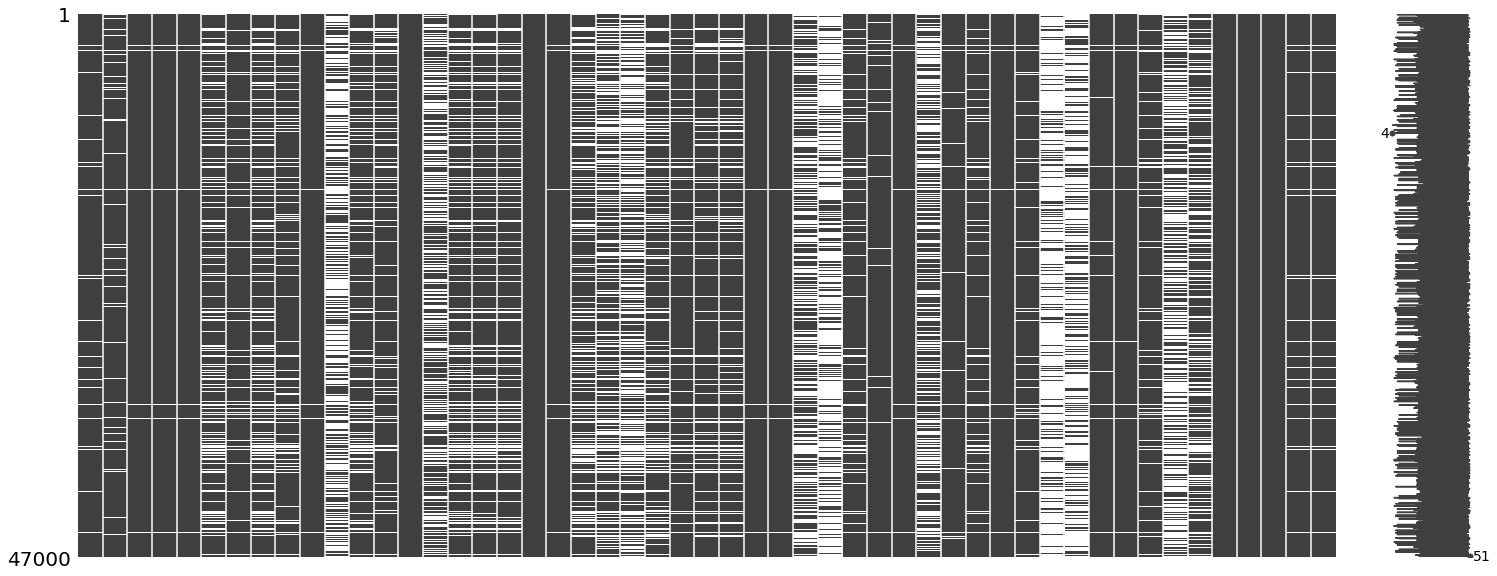

In [82]:
test_data = drop_columns(test_data,0.5)

In [83]:
#orginal duplicate of test_data
test_data_copy = pd.DataFrame(data=test_data,columns=test_data.columns,index=test_data.index)

In [84]:
#to make sure columns in train data used for model training is only considered for test data
test_data = pd.DataFrame(data=test_data,columns=testing.columns,index=test_data.index)

In [85]:
test_data.drop(['default_ind'],axis=1,inplace=True)

In [86]:
#missing value imputation

test_data_imputed = kernel.impute_new_data(test_data)
test_completed_data = test_data_imputed.complete_data(0)

In [87]:
#power transformation - normalization of data

test_data_transformed = pt.fit_transform(test_completed_data)
test_data_transformed = pd.DataFrame(data=test_data_transformed,columns=test_data.columns,index=test_data.index)

In [88]:
pca_testing_dataset = principal.transform(test_data_transformed)
pca_testing_dataset.shape

(47000, 28)

In [ ]:
#test_data_transformed - with transformation
#test_data - no transformation and imputation
#pca_testing_dataset - pca on transformed data

### Test Data - Model Output

In [91]:
test_cat_2_5 = model_cat_2_5.predict(test_data_transformed)
test_cat_2_6 = model_cat_2_6.predict(test_data_transformed) # Best performance - gave 60.42% accuracy on leaderboard
test_cat_2_7 = model_cat_2_6.predict(test_data_transformed)
test_cat_2_8 = model_cat_2_8.predict(test_data_transformed) # 2nd best performance - gave 60.13% accuracy on leaderboard
#test_cb_3 = model_cb_3.predict(test_data_transformed) # 3rd best performance - gave 60.04% accuracy on leaderboard

In [92]:
test_cat_2_6 = pd.DataFrame(data=test_cat_2_6,columns=['default_ind'],index=test_data_transformed.index)
test_cat_2_6.to_csv('Team_404_20.csv')